<a href="https://colab.research.google.com/github/eisbetterthanpi/MaskGIT/blob/main/MaskGIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://arxiv.org/pdf/2202.04200
# VQVAE, emb to ind
# transformer onehot index, cross entropy confidence
# For each training step, we uniformly sample t ∈ [0, 1) and randomly generate a mask m ∈ {0, 1}^H×W with N = ⌈γHW⌉ masked values, where γ = cos(π/2 *t)

## top

In [1]:
# @title gdown
import pickle
!gdown 1fYC7rJswDFpLeyywD56bu9ZjCQEyzRvY -O buffer512.pkl # S
with open('buffer512.pkl', 'rb') as f: buffer = pickle.load(f)

Downloading...
From (original): https://drive.google.com/uc?id=1fYC7rJswDFpLeyywD56bu9ZjCQEyzRvY
From (redirected): https://drive.google.com/uc?id=1fYC7rJswDFpLeyywD56bu9ZjCQEyzRvY&confirm=t&uuid=de1c35ea-b251-4ba2-9c00-7ea9e9758343
To: /content/buffer512.pkl
100% 706M/706M [00:08<00:00, 78.9MB/s]


In [2]:
# @title buffer dataloader
# RNNs https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR#scrollTo=IV5HmCFv_ITo
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
# import faiss
import random
import torchvision
import torch.nn.functional as F
import numpy as np

class BufferDataset(Dataset): # https://github.com/karpathy/minGPT
    def __init__(self, buffer, seq_len):
        self.data = [step for episode in buffer for step in episode] # 0.00053
        self.seq_len = seq_len
        # self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state, action, reward = self.data[idx]
        state = self.transform(state)
        return state

    def add(self, episode):
        self.data.append(episode)

from matplotlib import pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(3, 3))
    # print(npimg.shape) # (3, 64, 64)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


seq_len = 50 # 50
train_data = BufferDataset(buffer, seq_len) # one line of poem is roughly 50 characters
from torch.utils.data.dataloader import DataLoader
batch_size = 128 # 128 512
train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4

# train_data.data = train_data.data + episode


In [3]:
# @title RoPE
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class RoPE(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, seq_len=512, base=10000):
        super().__init__()
        theta = 1.0 / (base ** (torch.arange(0, dim, step=2) / dim))
        pos = torch.arange(seq_len).unsqueeze(1)
        angles = (pos * theta).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
        self.rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1).to(device) # [seq_len, dim // 2, 2]

    def forward(self, x):
        batch, seq_len, dim = x.shape
        # if rot_emb.shape[0] < seq_len: self.__init__(dim, seq_len)
        rot_emb = self.rot_emb[:seq_len].unsqueeze(0).expand(batch, -1, -1, -1) # [batch, seq_len, dim//2, 2]
        x = x.reshape(batch, seq_len, dim // 2, 2)
        rot_x = x * rot_emb
        return rot_x.flatten(-2)

dim=16
seq_len=512
rope = RoPE(dim, seq_len, base=10000)
x = torch.rand(4,64,dim, device=device)
out = rope(x)

print(out.shape)


torch.Size([4, 64, 16])


In [4]:
# @title FSQ me
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

def ste_round(x): return x.round().detach() + x - x.detach()

class FSQ(nn.Module):
    def __init__(self, levels):
        super().__init__()
        self.levels = torch.tensor(levels, device=device)
        self.basis = torch.cumprod(torch.tensor([*levels[1:], 1], device=device).flip(-1), dim=0).flip(-1)
        self.half_width = (self.levels-1)/2
        self.codebook_size = torch.prod(self.levels).item()
        # self.codebook = self.indexes_to_codes(torch.arange(self.codebook_size, device=device))
    @property
    def codebook(self): return self.indexes_to_codes(torch.arange(self.codebook_size, device=device))

    def forward(self, z, beta=1.0): # beta in (0,1). beta->0 => values more spread out
        offset = (self.levels+1) % 2 /2 # .5 if even, 0 if odd
        # bound = (F.sigmoid(2*z)-1/2) * (self.levels-beta) + offset
        bound = (F.tanh(z)/2) * (self.levels-beta) + offset
        quantized = ste_round(bound)
        return (quantized-offset) / self.half_width # split [-1,1]

    def codes_to_indexes(self, zhat):
        zhat = (zhat + 1) * self.half_width
        return (zhat * self.basis).sum(axis=-1).round().int()

    def indexes_to_codes(self, indices):
        indices = indices.unsqueeze(-1)
        codes = torch.remainder(indices//self.basis, self.levels)
        return codes / self.half_width - 1

# fsq = FSQ(levels = [128,4,3,2])
# # print(fsq.codebook)
# batch_size, seq_len = 2, 4
# # x = torch.linspace(-5,5,17).repeat(4,1).T # sig need larger variance to reach +-1
# x = torch.linspace(-3,3,17, device=device).repeat(4,1).T
# # x=la
# la = fsq(x)
# print(la)
# lact = fsq.codes_to_indexes(la)
# print(lact)
# la = fsq.indexes_to_codes(lact)
# print(la)

In [24]:
# @title ResBlock
import torch
import torch.nn as nn

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch=None, kernel=3):
        super().__init__()
        out_ch = out_ch or in_ch
        act = nn.SiLU() #
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        # self.block = nn.Sequential( # best?
        #     nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), act,
        #     zero_module(nn.Conv2d(out_ch, out_ch, 3, padding=1)), nn.BatchNorm2d(out_ch), act,
        #     )
        self.block = nn.Sequential(
            nn.BatchNorm2d(in_ch), act, nn.Conv2d(in_ch, out_ch, kernel, padding=kernel//2),
            nn.BatchNorm2d(out_ch), act, zero_module(nn.Conv2d(out_ch, out_ch, kernel, padding=kernel//2)),
            )

    def forward(self, x): # [b,c,h,w]
        return self.block(x) + self.res_conv(x)


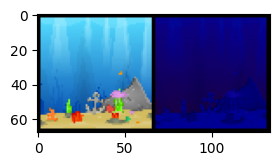

In [25]:
# @title UpDownBlock_me
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class PixelShuffleConv(nn.Module):
    def __init__(self, in_ch, out_ch=None, kernel=1, r=1):
        super().__init__()
        self.r = r
        r = max(r, int(1/r))
        out_ch = out_ch or in_ch
        d_model = 64
        if self.r>1: self.net = nn.Sequential(ResBlock(in_ch, out_ch*r**2, kernel), nn.PixelShuffle(r))
        elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), ResBlock(in_ch*r**2, out_ch, kernel))
        else: self.net = ResBlock(in_ch, out_ch, kernel)

    def forward(self, x):
        return self.net(x)

def adaptive_avg_pool_nd(n, x, output_size): return [nn.Identity(), F.adaptive_avg_pool1d, F.adaptive_avg_pool2d, F.adaptive_avg_pool3d][n](x, output_size)
def adaptive_max_pool_nd(n, x, output_size): return [nn.Identity(), F.adaptive_max_pool1d, F.adaptive_max_pool2d, F.adaptive_max_pool3d][n](x, output_size)

def adaptive_pool_at(x, dim, output_size, pool='avg'): # [b,c,h,w]
    x = x.transpose(dim,-1)
    shape = x.shape
    parent={'avg':F.adaptive_avg_pool1d, 'max':F.adaptive_max_pool1d}[pool]
    return parent(x.flatten(0,-2), output_size).unflatten(0, shape[:-1]).transpose(dim,-1)

def shortcut_fn(x, dim=1, c=3, sp=(3,3), nd=2):
    # x = adaptive_pool_at(x, dim, c, pool='max')
    # x = adaptive_max_pool_nd(nd, x, sp)
    x = adaptive_pool_at(x, dim, c, pool='avg')
    x = adaptive_avg_pool_nd(nd, x, sp)
    return x

class UpDownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=7, r=1):
        super().__init__()
        self.block = PixelShuffleConv(in_ch, out_ch, kernel=kernel, r=r)

    def forward(self, x): # [b,c,h,w]
        out = self.block(x)
        shortcut = shortcut_fn(x, dim=1, c=out.shape[1], sp=out.shape[-2:], nd=2)
        return out #+ shortcut

# in_ch, out_ch = 16,3
in_ch, out_ch = 3,16
# model = UpDownBlock(in_ch, out_ch, r=1/2).to(device)
model = UpDownBlock(in_ch, out_ch, r=2).to(device)
model1 = UpDownBlock(out_ch, in_ch, r=1/2).to(device)

# x = torch.rand(12, in_ch, 64,64, device=device)
# out = model(x)
# print(out.shape)

state = buffer[12][40][0]
transform = transforms.Compose([transforms.ToTensor()])
x = transform(state).unsqueeze(0).to(device)#[0]
sx = model(x)
out = model1(sx)
# print(x.shape,out.shape)

imshow(torchvision.utils.make_grid(torch.cat([x.cpu(), out.cpu()], dim=0), nrow=3))



In [7]:
# @title AttentionBlock
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads=None, cond_dim=None, dropout=0.): # .1
        super().__init__()
        self.d_model, self.n_heads, self.d_head = d_model, n_heads, d_model // n_heads
        self.cond_dim = cond_dim
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.kv = nn.Linear(cond_dim or d_model, 2*d_model, bias=False)
        self.lin = zero_module(nn.Linear(d_model, d_model))
        self.drop = nn.Dropout(dropout) # indp before q,k,v; after linout
        self.scale = self.d_head**-.5

    def forward(self, x, cond=None, mask=None): # [batch, T, d_model]=[batch, h*w, c], [batch, num_tok, cond_dim], [batch,T]
        if self.cond_dim==None: cond=x # is self attn
        q = self.q(x).unflatten(-1, (self.n_heads, self.d_head)).transpose(1, 2) # [batch, T, d_model] -> [batch, n_heads, T, d_head]
        # K = self.k(x).unflatten(-1, (self.n_heads, self.d_head)).transpose(1, 2)
        k, v = self.kv(cond).unflatten(-1, (self.n_heads, 2*self.d_head)).transpose(1, 2).chunk(2, dim=-1) # [batch, n_heads, T/num_tok, d_head]

        # # linear attention # Softmax(q) @ (Softmax(k).T @ v)
        if mask != None:
            mask = mask[:, None, :, None] # [batch,T] -> [batch,1,T,1]
            k, v = k.masked_fill(mask, -torch.finfo(x.dtype).max), v.masked_fill(mask, -torch.finfo(x.dtype).max)
        q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2)
        context = k.transpose(-2,-1) @ v # [batch, n_heads, d_head, d_head]
        out = q @ context # [batch, n_heads, T/num_tok, d_head]

        # # (quadratic) attention # Softmax(q @ k.T) @ v
        # out = F.scaled_dot_product_attention(q, k, v, attn_mask=mask.unsqueeze(1) if mask != None else None, dropout_p=0) # mask: [batch,len_q, len_v]
        # out = F.scaled_dot_product_attention(q, k, v, is_causal=True, dropout_p=0) # mask: [batch,len_q, len_v]
        # attn = q @ k.transpose(-2,-1) * self.scale # [batch, n_heads, T] # [batch, n_heads, T, T/num_tok]
        # # if mask != None: attn = attn.masked_fill(mask[:, None, :, None], -torch.finfo(attn.dtype).max) # [batch,T]->[batch,1,T,1]
        # if mask != None: attn = attn.masked_fill(mask.unsqueeze(1), -torch.finfo(attn.dtype).max) # [b,t,t]->[b,1,t,t]
        # attention = torch.softmax(attn, dim=-1)
        # out = self.drop(attention) @ v # [batch, n_heads, T, d_head]

        out = out.transpose(1,2).flatten(2)
        return self.drop(self.lin(out)) # [batch, T, d_model]

class AttentionBlock(nn.Module):
    def __init__(self, d_model, n_heads, cond_dim=None, mult=4, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.norm = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.drop = nn.Dropout(dropout)
        self.cond_dim = cond_dim
        self.attn = MultiHeadAttention(d_model, n_heads=n_heads, dropout=0) # 16448
        act = nn.GELU() # ReLU GELU
        ff_dim = d_model * mult
        self.ff = nn.Sequential(
            nn.RMSNorm(d_model), nn.Linear(d_model, ff_dim), act,
            nn.RMSNorm(ff_dim), nn.Dropout(dropout), zero_module(nn.Linear(ff_dim, d_model))
        )

    def forward(self, x, cond=None, mask=None): # [b,c,h,w], [batch, num_tok, cond_dim], [batch,T]
        # if self.cond_dim==None: cond=None # is self attn
        x = x + self.drop(self.attn(self.norm(x)))
        x = x + self.drop(self.ff(x))
        return x


import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        for layer in self:
            params = inspect.signature(layer.forward).parameters.keys()
            layer._fwdparams = ','.join(params)

    def forward(self, x, mask=None):
        for layer in self:
            args = [x]
            if 'mask' in layer._fwdparams: args.append(mask)
            x = layer(*args)
        return x


# d_model=64
# in_dim=16
# x = torch.rand(64, 3, d_model, device=device)
# model = AttentionBlock(d_model, n_heads=8)
# logits = model(x)
# print(logits.shape)


##sv

In [29]:
# @title transformer

def complement(x, length): # [b,t], int
    b = x.shape[0]
    device = x.device
    full = torch.arange(length, device=device).repeat(b,1)   # (length,)
    mask = torch.ones(b, length, dtype=bool, device=device)
    mask[torch.arange(b).unsqueeze(-1), x] = False
    return full[mask].reshape(b,-1)

# b = 2
# msk_len=4
# x = torch.stack([torch.randperm(10)[:msk_len] for _ in range(b)]) # [b,msk_len]
# print(x)
# print(complement(x,10))

class Transformer(nn.Module):
    def __init__(self, in_dim, d_model=64, out_dim=None, n_heads=8, n_layers=1, ff_dim=256, dropout=0):
        super().__init__()
        self.tok_emb = nn.Embedding(in_dim, d_model)
        # self.tok_emb = nn.Linear(in_dim, d_model)
        # self.pos_enc = RoPE(d_model, base=10000)
        self.pos_emb = nn.Parameter(torch.randn(1, 2000, d_model)*.02)
        self.block = Seq(*[AttentionBlock(d_model, n_heads, ff_dim, dropout) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_dim or in_dim)
        self.cls = nn.Parameter(torch.randn(1,1,d_model)*0.02) # randn zeros

    def forward(self, x, knw_mask=None, unk_mask=None): # [b,t], [b,t,t]
        x = self.tok_emb(x)
        b,t,_ = x.shape
        x = x + self.pos_emb[0,:t]
        # if knw_mask!=None and unk_mask!=None:
        if knw_mask!=None:
            x = x[torch.arange(b).unsqueeze(-1), knw_mask] # [batch, num_context_toks, d_model]
            # print('trans fwd', x.shape, self.pos_emb[0,knw_mask].shape)
            # x = x + self.pos_emb[0,knw_mask]

            if unk_mask==None: unk_mask = complement(knw_mask,t)
            pred_tokens = self.cls + self.pos_emb[0,unk_mask]
            # print('trans fwd', x.shape, pred_tokens.shape)
            x = torch.cat([x, pred_tokens], dim=1) # [batch, seq_len+num_trg_toks, d_model]
            ids = torch.cat([knw_mask,unk_mask], dim=1)
            # print('trans fwd', x.shape, ids[0], max(ids[0]))
            # x = torch.zeros_like(x).scatter(1, ids.unsqueeze(-1).repeat(1,1,x.shape[-1]), x)
            o = torch.empty_like(x)
            o[torch.arange(b).unsqueeze(-1), ids] = x
            x = o
        x = self.block(x)
        x = self.out(x)
        return x

d_model=4
in_dim=16
b,t=2,10
x = torch.randint(0, in_dim, (b, t), device=device)
# x = torch.rand(b,t,in_dim, device=device)
# model = Transformer(in_dim, d_model, out_dim=None, n_heads=8, n_layers=1)
model = Transformer(in_dim, d_model, out_dim=None, n_heads=1, n_layers=1).to(device)
# print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 59850

mask = torch.stack([torch.randperm(t)[:t] for _ in range(b)]).to(device)
# print(x)
print(mask)

# logits = model(x)
logits = model(x, mask)
print(logits.shape)



tensor([[8, 0, 4, 7, 1, 5, 2, 3, 9, 6],
        [7, 1, 9, 6, 5, 3, 0, 8, 4, 2]], device='cuda:0')
torch.Size([2, 10, 16])


In [9]:
# @title random_masking
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def random_masking(length, mask_ratio, b=64):
    noise = torch.rand(b, length, device=device)
    len_mask = int(length * mask_ratio)
    _, msk_ind = torch.topk(noise, k=len_mask, dim=-1, sorted=False) # val, ind -> [b,len_mask]
    _, keep_ind = torch.topk(noise, k=length-len_mask, largest=False, dim=-1, sorted=False) # val, ind -> [b,len_keep]
    return msk_ind, keep_ind

# msk_ind, keep_ind = random_masking(10, .3, b=2)

# x_ = torch.rand(4, 3, 2)
# print(x_)
# # ids = torch.tensor([0, 2, 1])[None,:,None]
# # ids = torch.tensor([0, 2, 1])[None,:,None].repeat(4,1,2)
# ids = torch.tensor([1, 2, 0])[None,:,None].repeat(4,1,2)
# # o = torch.gather(x_, dim=1, index=ids)
# o = torch.zeros_like(x_).scatter_(dim=1, index=ids, src=x_)
# print(o)


In [37]:
# @title MaskGIT
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def Cosine(x): # in [0,1]
    # k = unk_len*jax.lax.cos(math.pi/2 * ratio).clamp(1e-6, 1.)
    # torch.tensor(x)
    return torch.cos(torch.pi*x/2).clamp(0,1)

class MaskGIT(nn.Module):
    def __init__(self, in_ch=16, d_model=64, z_dim=3, n_head=8):
        super().__init__()
        # z_dim = z_dim or in_ch # z_channels z_dim
        self.encoder = nn.Sequential(
            UpDownBlock(in_ch, d_model, r=1/2),
            UpDownBlock(d_model, z_dim, r=1/2),
        )
        self.decoder = nn.Sequential(
            UpDownBlock(z_dim, d_model, r=2),
            UpDownBlock(d_model, in_ch, r=2),
        )
        self.vq = FSQ(levels = z_dim*[6]) # 1024
        self.transformer = Transformer(6**z_dim, d_model, out_dim=None, n_heads=n_head, n_layers=1)
        # self.transformer = Transformer(z_dim, d_model, out_dim=None, n_heads=n_head, n_layers=1)

    def loss(self, img, mask_len=None): # [b,c,h,w]
        x = self.encoder(img)
        bchw = x.shape
        # print('mskgit fwd', x.shape)
        z = self.vq(x.flatten(2).transpose(-2,-1)) # [b,t,d]
        b,t,_ = z.shape
        y = x = self.vq.codes_to_indexes(z) # [b,t]

        mask_len = mask_len or (Cosine(torch.rand(1))*t).int()
        knw_mask, unk_mask = random_masking(t, torch.rand(1), b=b)

        x = self.transformer(x, knw_mask, unk_mask)
        # print('mskgit fwd', x.shape, y.shape)
        trans_loss = F.cross_entropy(x[torch.arange(b).unsqueeze(-1), unk_mask].flatten(0,1), y.long()[torch.arange(b).unsqueeze(-1), unk_mask].flatten())

        z = z.transpose(-2,-1).reshape(*bchw)
        img_ = self.decoder(z)
        vqvae_loss = F.mse_loss(img, img_)
        # return trans_loss + vqvae_loss
        return trans_loss, vqvae_loss

    # def encode(self, x):
    #     x = self.encoder(x)
    #     return self.vq(x.flatten(2).transpose(-2,-1)) # [b,t,d]

    def decode(self, x, num_iter=12, temperature=1., start=.1):
        # x = self.encoder(x)
        b,c,h,w = x.shape
        x = self.vq(x.flatten(2).transpose(-2,-1)) # [b,t,d]
        x = self.vq.codes_to_indexes(x) # [b,t]

        knw_mask, unk_mask = random_masking(x.shape[1], start, b=b)
        # knw_mask, unk_mask = None, torch.arange(x.shape[1]).repeat(b,1).to(device)

        mask_len = (Cosine(torch.linspace(0,1,num_iter+1))*unk_mask.shape[1]).int()
        for i, (ksel, kunk) in enumerate(zip(mask_len[:-1]-mask_len[1:], mask_len[1:])):
            # print('ksel, kunk',ksel, kunk)
            logits = self.transformer(x, knw_mask, unk_mask) # [b,t,vocab_size]
            logits = logits[torch.arange(b).unsqueeze(-1), unk_mask]
            # print(logits.shape)
            probs = F.softmax(logits/temperature, dim=-1).flatten(0,1) # [b*num_unk, vocab_size]
            sampled_toks = torch.multinomial(probs, num_samples=1) # [b*num_unk, 1] rand sample by output distribution
            selected_probs = probs.gather(-1, sampled_toks).reshape(b,-1) # [b, num_unk] confidence of selected toks
            sampled_toks = sampled_toks.reshape(b,-1).int()
            _, sel_ind = torch.topk(selected_probs, k=ksel, dim=-1, sorted=False) # val, ind -> [b,k]
            _, unk_ind = torch.topk(selected_probs, k=kunk, largest=False, dim=-1, sorted=False) # val, ind -> [b,k]

            sel_mask, unk_mask = unk_mask[torch.arange(b).unsqueeze(-1), sel_ind], unk_mask[torch.arange(b).unsqueeze(-1), unk_ind]
            sel_tok = sampled_toks[torch.arange(b).unsqueeze(-1), sel_ind]

            # print('mskgit fwd', x.shape, sel_mask.shape, sel_tok.shape) # [b,t,vocab_size]
            x[torch.arange(b).unsqueeze(-1), sel_mask] = sel_tok # [b,t]/

            # if knw_mask==None: knw_mask = sel_mask ; else:
            knw_mask = torch.cat([knw_mask, sel_mask], dim=1)

        x = self.vq.indexes_to_codes(x) # [b,t]
        x = x.transpose(-2,-1).reshape(b,c,h,w)
        # x = self.decoder(x)
        return x

# start with known toks(bec rest is unk tok), -model> logits, sample to sampled toks
# probs=softmax(logits). selected_probs = probs of selected ind
# topk by confidence = jnp.log(selected_probs) + temperature * jax.random.gumbel(rng, probs.shape)

    # def quantise(self, x): # [b,c,h,w]->[b,h,w,c]->[b,c,h,w]
    #     # return self.vq(x.permute(0,2,3,1)).permute(0,3,1,2)
    #     return x


batch=25#64
in_ch=3
d_model=64
z_dim=4
h,w = 64,64
model = MaskGIT(in_ch, d_model, z_dim=z_dim, n_head=8).to(device)

x = torch.rand((batch, in_ch, h, w), device=device)

# out = model(x)
out = model.loss(x)
# out = model.encode(x)
# print(out.shape)

# x = torch.rand(64, 3, d_model, device=device)
# out = torch.randint(0, in_dim, (64, 3), device=device)

sx = model.encoder(x)
sx_ = model.decode(sx)
x_ = model.decoder(sx_)
# # x = model.quantise(x)
print(x_.shape)

optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
print(sum(p.numel() for p in model.transformer.parameters() if p.requires_grad)) # 19683
print(sum(p.numel() for p in model.encoder.parameters() if p.requires_grad)) # 19683
print(sum(p.numel() for p in model.decoder.parameters() if p.requires_grad)) # 19683


torch.Size([25, 3, 64, 64])
978208
311888
55804
610516


In [11]:
# @title wandb
!pip install -q wandb
import wandb # https://docs.wandb.ai/quickstart
wandb.login(key='487a2109e55dce4e13fc70681781de9f50f27be7')
try: run.finish()
except NameError: pass
run = wandb.init(project="maskgit", config={"model": "res18",})

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bobdole to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


0
trans_loss 7.124001502990723 vqvae_loss 0.08446752279996872
trans_loss 4.2933478355407715 vqvae_loss 0.021716078743338585
trans_loss 3.6470236778259277 vqvae_loss 0.014578334987163544
trans_loss 3.7495999336242676 vqvae_loss 0.013843292370438576
trans_loss 2.260627269744873 vqvae_loss 0.011330421082675457


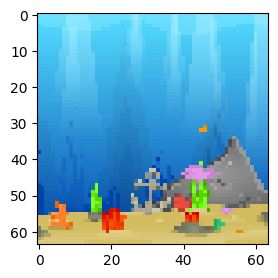

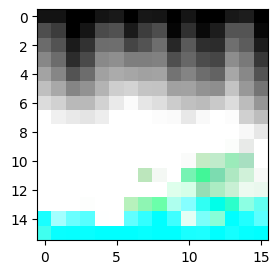

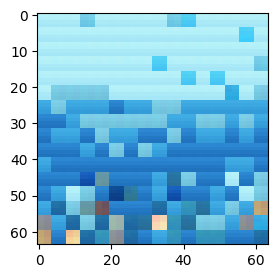

1
trans_loss 2.0937905311584473 vqvae_loss 0.01039083581417799
trans_loss 1.9070751667022705 vqvae_loss 0.010314026847481728
trans_loss 2.371431827545166 vqvae_loss 0.010034311562776566
trans_loss 2.090702772140503 vqvae_loss 0.009188396856188774
trans_loss 2.37908935546875 vqvae_loss 0.009074082598090172


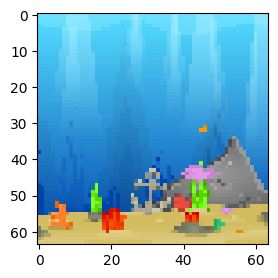

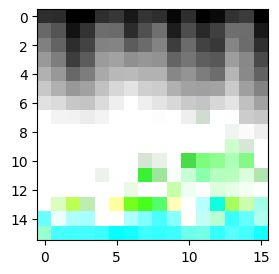

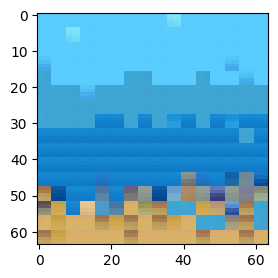

2
trans_loss 2.111605644226074 vqvae_loss 0.009064250625669956
trans_loss 2.215550422668457 vqvae_loss 0.009185254573822021
trans_loss 2.1758344173431396 vqvae_loss 0.008991530165076256
trans_loss 2.0650739669799805 vqvae_loss 0.008902069181203842
trans_loss 2.038510322570801 vqvae_loss 0.008672617375850677


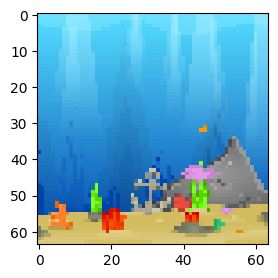

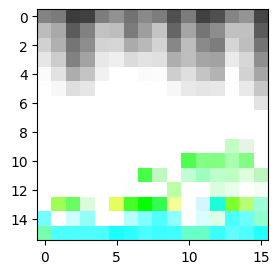

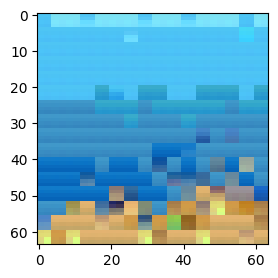

3
trans_loss 2.3073413372039795 vqvae_loss 0.008836094290018082
trans_loss 1.9609450101852417 vqvae_loss 0.008097993209958076
trans_loss 2.024603843688965 vqvae_loss 0.008248656056821346
trans_loss 2.0859785079956055 vqvae_loss 0.008165998384356499
trans_loss 2.0841400623321533 vqvae_loss 0.008517436683177948


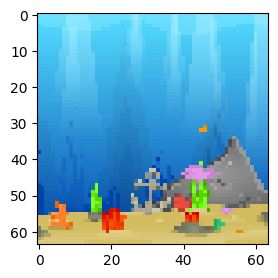

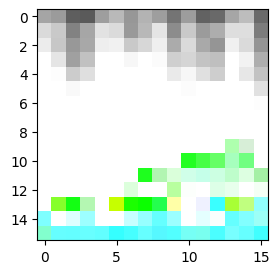

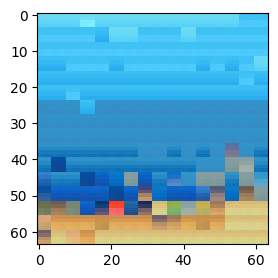

4
trans_loss 2.080288887023926 vqvae_loss 0.008390038274228573
trans_loss 2.4001951217651367 vqvae_loss 0.008313249796628952
trans_loss 2.0915873050689697 vqvae_loss 0.008510465733706951
trans_loss 2.0304408073425293 vqvae_loss 0.008003590628504753
trans_loss 1.9895213842391968 vqvae_loss 0.00817575678229332


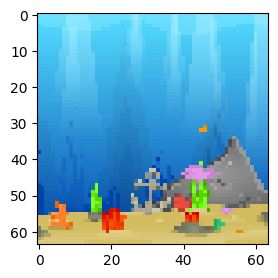

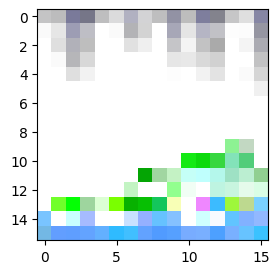

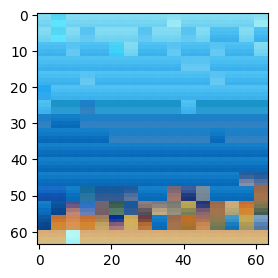

5
trans_loss 2.0970849990844727 vqvae_loss 0.008283124305307865
trans_loss 1.8740960359573364 vqvae_loss 0.008078196085989475
trans_loss 1.9861923456192017 vqvae_loss 0.008340860716998577
trans_loss 1.8520755767822266 vqvae_loss 0.007838881574571133
trans_loss 1.986716389656067 vqvae_loss 0.008065841160714626


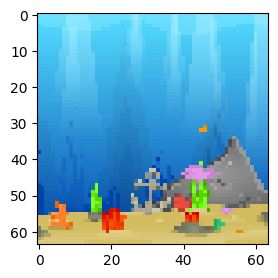

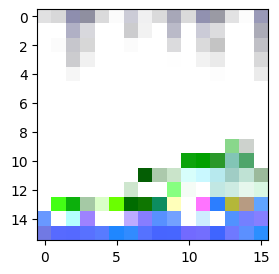

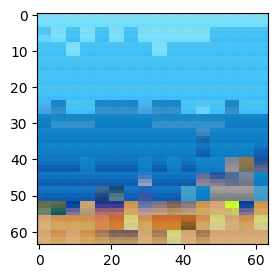

6
trans_loss 2.2494826316833496 vqvae_loss 0.007948244921863079
trans_loss 2.1101179122924805 vqvae_loss 0.007917257957160473
trans_loss 2.040415048599243 vqvae_loss 0.007861815392971039
trans_loss 2.2092196941375732 vqvae_loss 0.008157888427376747
trans_loss 1.9424586296081543 vqvae_loss 0.007861766964197159


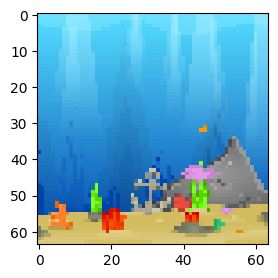

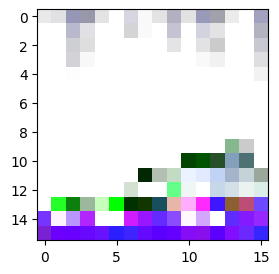

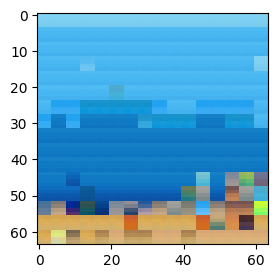

7
trans_loss 2.1122043132781982 vqvae_loss 0.007355347275733948
trans_loss 1.8555243015289307 vqvae_loss 0.007491788826882839
trans_loss 1.9129853248596191 vqvae_loss 0.007780097424983978
trans_loss 1.8636960983276367 vqvae_loss 0.007811041548848152
trans_loss 1.8474223613739014 vqvae_loss 0.0076476274989545345


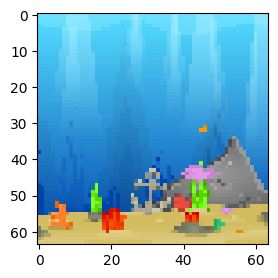

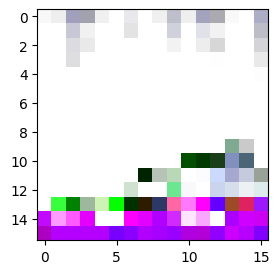

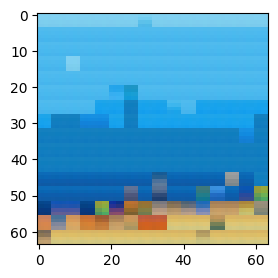

8
trans_loss 1.8332799673080444 vqvae_loss 0.008020224049687386
trans_loss 1.8612112998962402 vqvae_loss 0.007644999772310257
trans_loss 1.867075800895691 vqvae_loss 0.007817131467163563
trans_loss 1.9225367307662964 vqvae_loss 0.007575027644634247
trans_loss 1.9117612838745117 vqvae_loss 0.007867575623095036


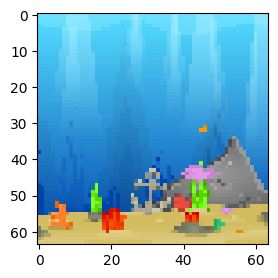

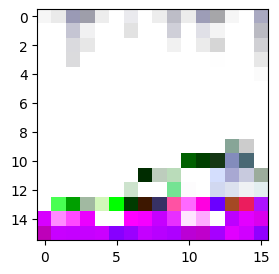

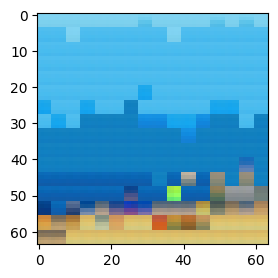

9
trans_loss 1.905552625656128 vqvae_loss 0.007553432136774063
trans_loss 1.795066237449646 vqvae_loss 0.007370229810476303
trans_loss 1.7840757369995117 vqvae_loss 0.007259766571223736
trans_loss 1.8896522521972656 vqvae_loss 0.008060014806687832
trans_loss 1.816933035850525 vqvae_loss 0.007619721349328756


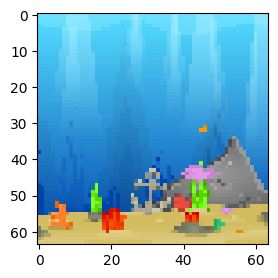

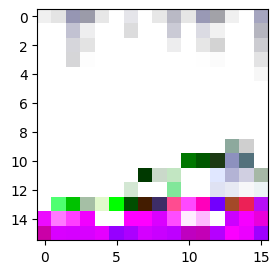

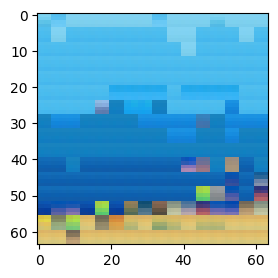

In [12]:
# @title train
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.GradScaler(device)

def train(model, optim, dataloader, scheduler=None):
    model.train()
    for i, x in enumerate(dataloader):
        x = x.to(device)
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # float16 cannot?
            # loss = model.loss(x)
            trans_loss, vqvae_loss = model.loss(x)
            loss = trans_loss + vqvae_loss
        optim.zero_grad()
        scaler.scale(loss).backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # clip gradients
        scaler.step(optim)
        scaler.update()

        if scheduler is not None: scheduler.step()
        # try: wandb.log({"loss": loss.item()})
        try: wandb.log({"trans_loss": trans_loss.item(), "vqvae_loss": vqvae_loss.item()})
        except NameError: pass
        # if i % 100 == 0: print(loss.item())
        if i % 100 == 0: print("trans_loss", trans_loss.item(), "vqvae_loss", vqvae_loss.item())


# for i in range(1):
for i in range(10): # 10
    print(i)
    train(model, optim, train_loader)

    model.eval()
    with torch.no_grad():
        state = buffer[12][40][0]
        transform = transforms.Compose([transforms.ToTensor()])
        x = transform(state).unsqueeze(0).to(device)
        sx = model.encoder(x)
        # out = model.decoder(sx)
        out = model.decode(x)
        imshow(torchvision.utils.make_grid(x.cpu()))
        imshow(torchvision.utils.make_grid(sx.cpu()))
        imshow(torchvision.utils.make_grid(out.cpu()))


torch.Size([1, 3, 64, 64]) torch.Size([1, 3, 64, 64]) torch.Size([1, 4, 16, 16]) torch.Size([1, 4, 16, 16]) torch.Size([1, 3, 64, 64])


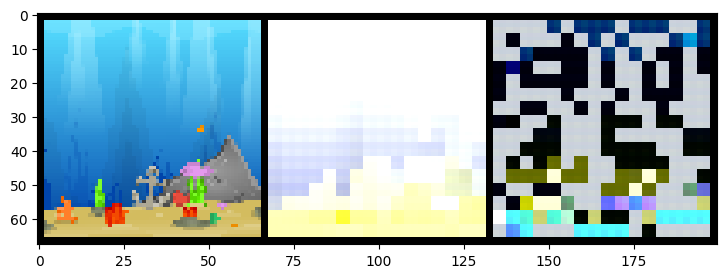

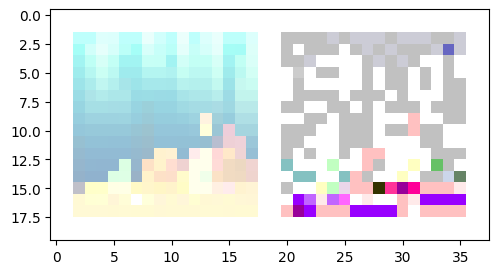

In [43]:
from matplotlib import pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 3))
    # print(npimg.shape) # (3, 64, 64)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


model.eval()
with torch.no_grad():
    state = buffer[12][40][0]
    transform = transforms.Compose([transforms.ToTensor()])
    x = transform(state).unsqueeze(0).to(device)#[0]
    sx = model.encoder(x)
    x_ = model.decoder(sx)
    sx_ = model.decode(sx, num_iter=12, temperature=1., start=.5)
    out = model.decoder(sx_)

    print(x.shape, x_.shape, sx.shape, sx_.shape, out.shape)

    # imshow(torchvision.utils.make_grid(x.cpu()))
    # imshow(torchvision.utils.make_grid(sx.cpu()))
    imshow(torchvision.utils.make_grid(torch.cat([x.cpu(), x_.cpu(), out.cpu()], dim=0), nrow=3))
    imshow(torchvision.utils.make_grid(torch.cat([sx.cpu(), sx_.cpu()], dim=0), nrow=2))
    # imshow(torchvision.utils.make_grid(out.cpu()))


In [42]:
# @title save/load
# from google.colab import drive
# drive.mount('/content/drive')
# folder='/content/drive/MyDrive/jepa/'

# modelsd, optimsd = torch.load(folder+'maskgit.pkl', map_location=device).values()
modelsd, optimsd = torch.load('maskgit.pkl', map_location=device).values()
model.load_state_dict(modelsd, strict=False)
optim.load_state_dict(optimsd)


In [20]:
checkpoint = {'model': model.state_dict(), 'optimizer': optim.state_dict()}
# checkpoint = {'model': model_mlm.state_dict()}
# torch.save(checkpoint, folder+'maskgit.pkl')
torch.save(checkpoint, 'maskgit.pkl')

## drawer

In [ ]:

def entropy(scores): # [batch, seq_len, vocab]
    """Computes the entropy for each token in the batch. Note: uses natural log."""
    log_probs = F.log_softmax(scores, dim=-1)
    probs = torch.exp(log_probs)
    p_log_p = log_probs * probs
    entropy = -p_log_p.sum(dim=-1)
    return entropy # [batch, seq_len]


In [ ]:
t=1024
b=128
x=torch.rand(b,t,128)
# print(x)
mask = torch.stack([torch.randperm(t)[:t] for _ in range(b)])
# print(mask)
# x = x.gather(1, mask.unsqueeze(-1))
o = torch.zeros_like(x).scatter(1, mask.unsqueeze(-1).repeat(1,1,x.shape[-1]), x) # unsort from inds
# print(o)
o = torch.empty_like(x)
x[torch.arange(b).unsqueeze(-1), mask] = x
# print(o)
# %timeit o = torch.zeros_like(x).scatter(1, mask.unsqueeze(-1).repeat(1,1,x.shape[-1]), x) # 3.51 ms
%timeit o = torch.empty_like(x);o[torch.arange(b).unsqueeze(-1), mask] = x # 3.92 ms 5.19 6.21


In [ ]:
# @title multiblock2d
def multiblock2d(hw=(8,8), scale=(.15,.2), aspect_ratio=(.75,1.5), M=1):
    mask_aspect = torch.rand(1) * (aspect_ratio[1] - aspect_ratio[0]) + aspect_ratio[0] # in (min_s, max_s) # all blocks same size
    mask_scale = torch.rand(1) * (scale[1] - scale[0]) + scale[0] # in (min_s, max_s) # all blocks same size
    h = (mask_scale/mask_aspect)**.5# h*(h*aspect) = scale
    w = h * mask_aspect
    # h_pos, w_pos = torch.rand(M)*(1-w), torch.rand(M)*(1-h) # in (0, 1 - mask_len)
    # h_len, h_pos = (h*hw[0]).int(), h_pos*hw[0]
    # w_len, w_pos = (w*hw[1]).int(), w_pos*hw[1]

    h_len, w_len = (h*hw[0]).int(), (w*hw[1]).int()
    h_pos, w_pos = torch.rand(M)*(hw[1]-w_len), torch.rand(M)*(hw[0]-h_len) # in (0, 1 - mask_len)


    h_ind, w_ind = torch.arange(hw[0]).unsqueeze(0), torch.arange(hw[1]).unsqueeze(0) # [1, seq]
    h_mask = (h_ind>=h_pos.unsqueeze(-1)) & (h_ind<(h_pos+h_len).unsqueeze(-1)) # [M, seq]
    w_mask = (w_ind>=w_pos.unsqueeze(-1)) & (w_ind<(w_pos+w_len).unsqueeze(-1)) # [M, seq]
    target_mask = h_mask.unsqueeze(-1) & w_mask.unsqueeze(-2) # [M, seq, seq]
    return target_mask

# b=25
# mask = multiblock2d(hw=(8,8), scale=(.15,.2), aspect_ratio=(.75,1.5), M=b)#.squeeze(0)
# print(mask)
# # print(mask.flatten(1).sum(1))
# print(mask.flatten(1).nonzero()[:,1].reshape(b,-1).shape)
# # mask = mask.flatten(1).nonzero()[:,1].reshape(b,-1)
# # mask = mask.flatten().nonzero().reshape(1,-1)
# # mask = mask.nonzero().reshape(1,-1)
# # print(mask)


In [ ]:
# @title VQVAE me

class VQVAE(nn.Module):
    def __init__(self, in_ch=3, d_model=16, out_ch=None, depth=4, num_res_blocks=1, n_head=-1, d_head=4):
        super().__init__()
        self.in_ch = in_ch
        self.d_model = d_model # base channel count for the model
        out_ch = out_ch or in_ch # z_channels z_dim
        # n_head = d_model // d_head
        # self.vq = VectorQuantizerEMA(num_emb=8192, emb_dim=out_ch, beta=0.5) # chat gpt
        # self.vq = FSQ(levels = z_dim*[32])

        mult = [1,1,1,1]
        # mult = [1,2,3,4] # [1,2,3,4] [1,2,2,2]
        ch_list = [d_model * m for m in mult] # [128, 256, 384, 512]

        self.encoder = nn.Sequential(
            # nn.Conv2d(in_ch, ch_list[0], 3, 1, padding=3//2),

            ResBlock(in_ch, ch_list[0]),
            # ResBlock(ch_list[0], ch_list[1]),
            # ResBlock(ch_list[1], ch_list[1]),
            AttentionBlock(ch_list[0], d_head),

            # nn.PixelUnshuffle(2),
            # ResBlock(ch_list[0]*2**2, ch_list[1]),
            # nn.AvgPool2d(2,2),
            # nn.MaxPool2d(2,2),
            UpDownBlock(3, ch_list[0], r=1/2),

            ResBlock(ch_list[0], ch_list[1]),
            # ResBlock(ch_list[2], ch_list[2]),
            AttentionBlock(ch_list[1], d_head),
            # ResBlock(ch_list[1], ch_list[2]),

            # nn.PixelUnshuffle(2),
            # ResBlock(ch_list[2]*2**2, ch_list[3]),
            # nn.AvgPool2d(2,2),
            UpDownBlock(ch_list[0], out_ch, r=1/2),

            ResBlock(ch_list[2], ch_list[3]),
            AttentionBlock(ch_list[3], d_head),
            # ResBlock(ch_list[3], ch_list[3]),
            ResBlock(ch_list[3], out_ch),

            # # nn.GroupNorm(32, ch_list[-1]), nn.SiLU(), nn.Conv2d(ch_list[-1], out_ch, 3, 1, padding=3//2)
            # nn.BatchNorm2d(ch_list[-1]), nn.SiLU(), nn.Conv2d(ch_list[-1], out_ch, 3, 1, padding=3//2)
        )

        self.decoder = nn.Sequential(
            # nn.Conv2d(out_ch, ch_list[-1], 3, 1, padding=3//2),

            ResBlock(out_ch, ch_list[3]),
            # ResBlock(ch_list[3], ch_list[3]),
            AttentionBlock(ch_list[3], d_head),
            ResBlock(ch_list[3], ch_list[2]),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            UpDownBlock(out_ch, ch_list[0], r=2),

            # ResBlock(ch_list[3], ch_list[2]*2**2),
            # # AttentionBlock(ch_list[2]*2**2, d_head),
            # nn.PixelShuffle(2),

            ResBlock(ch_list[2], ch_list[1]),
            AttentionBlock(ch_list[2], d_head),
            # ResBlock(ch_list[1], ch_list[0]),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            UpDownBlock(ch_list[0], in_ch, r=2),
            # ResBlock(ch_list[1], ch_list[0]*2**2),
            # nn.PixelShuffle(2),

            ResBlock(ch_list[1], ch_list[0]),
            AttentionBlock(ch_list[0], d_head),
            ResBlock(ch_list[0], in_ch),

            # # nn.GroupNorm(32, ch_list[0]), nn.SiLU(), nn.Conv2d(ch_list[0], in_ch, 3, 1, padding=3//2)
            # nn.BatchNorm2d(ch_list[0]), nn.SiLU(), zero_module(nn.Conv2d(ch_list[0], in_ch, 3, 1, padding=3//2)) # zero
        )

    # def forward(self, x):
    #     x = self.encoder(x)
    #     # print(x.shape)
    #     commitment_loss, x, _ = self.vq(x)
    #     # print(x.shape)
    #     x = self.decoder(x)
    #     return x, commitment_loss

    # def encode(self, x):
    #     x = self.encoder(x)
    #     _, x, _ = self.vq(x)
    #     return x

    # def decode(self, x):
    #     _, x, _ = self.vq(x)
    #     return self.decoder(x)

    def forward(self, x):
        x = self.encoder(x)
        # x = self.quantise(x)
        # print(x.shape)
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)
        # return self.quantise(x)
        return x
    def decode(self, x):
        # _, x, _ = self.vq(x)
        # x = self.quantise(x)
        return self.decoder(x)
    def quantise(self, x): # [b,c,h,w]->[b,h,w,c]->[b,c,h,w]
        return self.vq(x.permute(0,2,3,1)).permute(0,3,1,2)



batch=2
in_ch=3
z_dim=3
h,w = 64,64
model = VQVAE(in_ch, d_model=16, out_ch=z_dim, depth=4, num_res_blocks=1, n_head=-1, d_head=4).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683

x = torch.rand((batch, in_ch, h, w), device=device)
# out, _ = model(x)
# print(out.shape)
# x = model.quantise(x)
# print(x.shape)
# print(x)


98950


In [ ]:
# @title mit-han-lab/efficientvit dc_ae.py down
# https://github.com/mit-han-lab/efficientvit/blob/master/efficientvit/models/efficientvit/dc_ae.py
import torch
import torch.nn as nn

class DCAE(nn.Module):
    def __init__(self, in_ch=3, out_ch=4, d_model=16, mult=[1], depth_list=[1,1]):
        super().__init__()
        width_list=[d_model*m for m in mult]
        # encoder mult=[1,2,4,4,8,8] # depth_list=[0,4,8,2,2,2]
        # decoder mult=[1,2,4,4,8,8] # depth_list=[0,5,10,2,2,2]

        self.encoder = nn.Sequential(
            nn.Conv2d(in_ch, width_list[0], 3, 2, padding=3//2),

            UpDownBlock(width_list[0], width_list[0], r=1/2),
            ResBlock(width_list[0]),
            UpDownBlock(width_list[0], width_list[-1], r=1/2),
            ResBlock(width_list[-1]),
            AttentionBlock(width_list[-1], d_head=4),
            UpDownBlock(width_list[-1], out_ch, r=1),
        )
        self.decoder = nn.Sequential(
            UpDownBlock(out_ch, width_list[-1], r=1),
            AttentionBlock(width_list[-1], d_head=4),
            ResBlock(width_list[-1]),
            UpDownBlock(width_list[-1], width_list[0], r=2),
            ResBlock(width_list[0]),
            nn.BatchNorm2d(width_list[0]), nn.ReLU(), UpDownBlock(width_list[0], width_list[0], r=2),
            nn.ConvTranspose2d(width_list[0], in_ch, 3, 2, padding=3//2, output_padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

in_ch=3
out_ch=3
# 3*2^2|d_model
model = DCAE(in_ch, out_ch, d_model=16, mult=[1,1], depth_list=[1,1]).to(device)
# print(sum(p.numel() for p in model.stages.parameters() if p.requires_grad)) # 4393984
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
x = torch.rand((2,in_ch,64,64), device=device)
sx = model.encoder(x)
print(sx.shape)
out = model.decoder(sx)
# out = model(x)
print(out.shape)


## other maskgit

In [ ]:
# @title google-research parallel_decode.py down
# https://github.com/google-research/maskgit/blob/main/maskgit/libml/parallel_decode.py

def mask_by_random_topk(mask_len, probs, temperature=1.0):
    confidence = jnp.log(probs) + temperature * jax.random.gumbel(probs.shape)
    sorted_confidence = jnp.sort(confidence, axis=-1)
    # Obtains cut off threshold given the mask lengths.
    cut_off = jnp.take_along_axis(sorted_confidence, mask_len, axis=-1)
    # Masks tokens with lower confidence.
    masking = (confidence < cut_off)
    return masking

def decode(inputs, rng, tokens_to_logits, mask_token_id=-1, num_iter=12, choice_temperature=1.0, mask_scheduling_method="cosine"):
  """Fast decoding for iterative generation.
    inputs: int32 array: [batch_size, seq_length] input sequence of masked tokens, where the masking tokens is defined by mask_token_id.
    rng: jnp.DeviceArray: sampling random state.
    tokens_to_logits: decoder function taking single token slices and cache and returning logits and updated cache.
    mask_token_id: int: [Mask] token id.
    choice_temperature: float: temperature to control the randomness of masking.
  Returns: [batch_size, num_iter, seq_length] output sequence of tokens in all iterations.
  """
  unknown_number_in_the_beginning = jnp.sum(inputs == mask_token_id, axis=-1)
  # Initializes state
  state = state_init(inputs, rng, num_iter, start_iter=0)

  while step < num_iter:
    """Beam search loop state update function."""
    # Current input ids: [batch_size, seq_length].
    cur_ids = state.cur_seqs

    # Calls model on current seqs to get next-iteration seqs.
    logits = tokens_to_logits(cur_ids)
    # Samples the ids using categorical sampling: [batch_size, seq_length].
    sampled_ids = jax.random.categorical(logits) # sample based on softmax(logits)

    # Just updates the masked tokens.
    unknown_map = (cur_ids == mask_token_id)
    sampled_ids = jnp.where(unknown_map, sampled_ids, cur_ids)
    # Defines the mask ratio for the next round. The number to mask out is
    # determined by mask_ratio * unknown_number_in_the_beginning.
    ratio = 1. * (step + 1) / num_iter
    # mask_ratio = mask_schedule.schedule(ratio, unknown_number_in_the_beginning, mask_scheduling_method)
    mask_ratio = jax.lax.cos(math.pi / 2. * ratio)
    mask_ratio = jnp.clip(mask_ratio, 1e-6, 1.)

    # Updates final seqs with the current sampled_ids.
    final_seqs = jax.lax.dynamic_update_slice(state.final_seqs, jnp.expand_dims(sampled_ids, axis=1), (0, step, 0)) # insert block at pos
    # Computes the probabilities of each selected tokens.
    probs = jax.nn.softmax(logits, axis=-1) # [b,t,d]
    selected_probs = jnp.squeeze(jnp.take_along_axis(probs, jnp.expand_dims(sampled_ids, -1), -1), -1)
    # Ignores the tokens given in the input by overwriting their confidence.
    selected_probs = jnp.where(unknown_map, selected_probs, _CONFIDENCE_OF_KNOWN_TOKENS)
    # Gets mask lens for each sample in the batch according to the mask ratio.
    mask_len = jnp.expand_dims(jnp.floor(unknown_number_in_the_beginning * mask_ratio), 1)
    # Keeps at least one of prediction in this round and also masks out at least one and for the next iteration
    mask_len = jnp.maximum(1, jnp.minimum(jnp.sum(unknown_map, axis=-1, keepdims=True) - 1, mask_len))

    # Adds noise for randomness
    masking = mask_by_random_topk(mask_len, selected_probs, choice_temperature * (1. - ratio))
    # Masks tokens with lower confidence.
    sampled_ids = jnp.where(masking, mask_token_id, sampled_ids)
    final_state = State(cur_index=state.cur_index + 1, cur_seqs=sampled_ids, rng=rng, final_seqs=final_seqs)
  return final_state.final_seqs

# start with toks(rest is unk tok), -model> logits, sample to sampled toks
# probs=softmax(logits). selected_probs = probs of swelected ind
# topk by confidence = jnp.log(selected_probs) + temperature * jax.random.gumbel(rng, probs.shape)




In [ ]:
# @title google-research parallel_decode.py
# https://github.com/google-research/maskgit/blob/main/maskgit/libml/parallel_decode.py

def mask_by_random_topk(rng=0, mask_len, probs, temperature=1.0):
    confidence = jnp.log(probs) + temperature * jax.random.gumbel(rng, probs.shape)
    sorted_confidence = jnp.sort(confidence, axis=-1)
    # Obtains cut off threshold given the mask lengths.
    cut_off = jnp.take_along_axis(sorted_confidence, mask_len.astype(jnp.int32), axis=-1)
    # Masks tokens with lower confidence.
    masking = (confidence < cut_off)
    return masking

def decode(inputs, rng, tokens_to_logits, mask_token_id=-1, num_iter=12, start_iter=0, choice_temperature=1.0, mask_scheduling_method="cosine"):
  """Fast decoding for iterative generation.
    inputs: int32 array: [batch_size, seq_length] input sequence of masked tokens, where the masking tokens is defined by mask_token_id.
    rng: jnp.DeviceArray: sampling random state.
    tokens_to_logits: decoder function taking single token slices and cache and returning logits and updated cache.
    mask_token_id: int: [Mask] token id.
    num_iter: int: default is 12.
    start_iter: int: default is 0.
    choice_temperature: float: temperature to control the randomness of masking.
    mask_scheduling_method: masking method string. See mask_schedule.py for details.
  Returns: [batch_size, num_iter, seq_length] output sequence of tokens in all iterations.
  """
  unknown_number_in_the_beginning = jnp.sum(inputs == mask_token_id, axis=-1)
  # Initializes state
  state = state_init(inputs, rng, num_iter, start_iter=start_iter)

  while state.cur_index < num_iter:
    """Beam search loop state update function."""
    rng = state.rng
    step = state.cur_index
    # Current input ids: [batch_size, seq_length].
    cur_ids = state.cur_seqs

    # Calls model on current seqs to get next-iteration seqs.
    logits = tokens_to_logits(cur_ids)
    rng, sample_rng = jax.random.split(rng, 2) # generate an arbitrary number of independent pseudorandom values given a single key
    # Samples the ids using categorical sampling: [batch_size, seq_length].
    sampled_ids = jax.random.categorical(sample_rng, logits) # sample based on softmax(logits)

    # Just updates the masked tokens.
    unknown_map = (cur_ids == mask_token_id)
    sampled_ids = jnp.where(unknown_map, sampled_ids, cur_ids)
    # Defines the mask ratio for the next round. The number to mask out is
    # determined by mask_ratio * unknown_number_in_the_beginning.
    ratio = 1. * (step + 1) / num_iter
    mask_ratio = mask_schedule.schedule(ratio, unknown_number_in_the_beginning, mask_scheduling_method)
    # Updates final seqs with the current sampled_ids.
    final_seqs = jax.lax.dynamic_update_slice(state.final_seqs, jnp.expand_dims(sampled_ids, axis=1), (0, step, 0)) # insert block at pos
    # Computes the probabilities of each selected tokens.
    probs = jax.nn.softmax(logits, axis=-1)
    selected_probs = jnp.squeeze(jnp.take_along_axis(probs, jnp.expand_dims(sampled_ids.astype(jnp.int32), -1), -1), -1)
    # Ignores the tokens given in the input by overwriting their confidence.
    selected_probs = jnp.where(unknown_map, selected_probs, _CONFIDENCE_OF_KNOWN_TOKENS)
    # Gets mask lens for each sample in the batch according to the mask ratio.
    mask_len = jnp.expand_dims(jnp.floor(unknown_number_in_the_beginning * mask_ratio), 1)
    # Keeps at least one of prediction in this round and also masks out at least one and for the next iteration
    mask_len = jnp.maximum(1, jnp.minimum(jnp.sum(unknown_map, axis=-1, keepdims=True) - 1, mask_len))

    # Adds noise for randomness
    rng, choice_rng = jax.random.split(rng) # generate an arbitrary number of independent pseudorandom values given a single key
    masking = mask_by_random_topk(choice_rng, mask_len, selected_probs, choice_temperature * (1. - ratio))
    # Masks tokens with lower confidence.
    sampled_ids = jnp.where(masking, mask_token_id, sampled_ids)
    final_state = State(cur_index=state.cur_index + 1, cur_seqs=sampled_ids, rng=rng, final_seqs=final_seqs)

  return final_state.final_seqs



In [ ]:
# @title hmorimitsu/maskgit-torch
# https://github.com/hmorimitsu/maskgit-torch/tree/main/maskgit/nets

embed = self.blocks(embed)
embed = self.Token_Prediction(embed)
logits = torch.matmul(embed, self.tok_emb.weight.T)
logits = logits + self.bias[None]
return logits


In [ ]:
# @title dome272/MaskGIT-pytorch
# https://github.com/dome272/MaskGIT-pytorch
# https://github.com/dome272/MaskGIT-pytorch/blob/main/transformer.py#L11
from transformer import VQGANTransformer

class TrainTransformer:
    def __init__(self, args):
        self.model = VQGANTransformer(args).to(device=args.device)
        self.train(args)

    def train(self, args):
        train_dataset = load_data(args)
        len_train_dataset = len(train_dataset)
        for epoch in range(args.start_from_epoch+1, args.epochs+1):
            print(f"Epoch {epoch}:")
            with tqdm(range(len(train_dataset))) as pbar:
                for i, imgs in zip(pbar, train_dataset):
                    imgs = imgs.to(device=args.device)
                    logits, target = self.model(imgs)
                    loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
                    loss.backward()
                    self.optim.step()
                    self.optim.zero_grad()
                    pbar.set_postfix(Transformer_Loss=np.round(loss.cpu().detach().numpy().item(), 4))



In [ ]:
# @title dome272 VQGANTransformer
# https://github.com/dome272/MaskGIT-pytorch/blob/main/transformer.py#L11
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from bidirectional_transformer import BidirectionalTransformer
_CONFIDENCE_OF_KNOWN_TOKENS = torch.Tensor([torch.inf]).to("cuda")


class VQGANTransformer(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.num_image_tokens = args.num_image_tokens
        self.sos_token = args.num_codebook_vectors + 1
        self.mask_token_id = args.num_codebook_vectors
        self.choice_temperature = 4.5

        self.gamma = self.gamma_func("cosine")

        # self.transformer = BidirectionalTransformer(
        #                         patch_size=8, embed_dim=args.dim, depth=args.n_layers, num_heads=12, mlp_ratio=4, qkv_bias=True,
        #                         norm_layer=partial(nn.LayerNorm, eps=1e-6), vocab_size=8192+1)
        self.transformer = BidirectionalTransformer(args)
        self.vqgan = self.load_vqgan(args)
        print(f"Transformer parameters: {sum([p.numel() for p in self.transformer.parameters()])}")

    @torch.no_grad()
    def encode_to_z(self, x):
        # quant_z, indices, _ = self.vqgan.encode(x)
        quant_z, _, (_, _, indices) = self.vqgan.encode(x)
        indices = indices.view(quant_z.shape[0], -1)
        return quant_z, indices

    def forward(self, x):
        # _, z_indices = self.encode_to_z(x)
        #
        # r = np.random.uniform()
        # mask = torch.bernoulli(r * torch.ones(z_indices.shape[-1], device=z_indices.device))
        # mask = mask.round().bool()
        #
        # target = z_indices[:, mask]
        #
        # logits = self.transformer(z_indices, mask)

        _, z_indices = self.encode_to_z(x)
        sos_tokens = torch.ones(x.shape[0], 1, dtype=torch.long, device=z_indices.device) * self.sos_token

        r = math.floor(self.gamma(np.random.uniform()) * z_indices.shape[1])
        sample = torch.rand(z_indices.shape, device=z_indices.device).topk(r, dim=1).indices
        mask = torch.zeros(z_indices.shape, dtype=torch.bool, device=z_indices.device)
        mask.scatter_(dim=1, index=sample, value=True)

        # torch.rand(z_indices.shape, device=z_indices.device)
        # mask = torch.bernoulli(r * torch.ones(z_indices.shape, device=z_indices.device))
        # mask = torch.bernoulli(torch.rand(z_indices.shape, device=z_indices.device))
        # mask = mask.round().to(dtype=torch.int64)
        # masked_indices = torch.zeros_like(z_indices)
        masked_indices = self.mask_token_id * torch.ones_like(z_indices, device=z_indices.device)
        a_indices = mask * z_indices + (~mask) * masked_indices
        a_indices = torch.cat((sos_tokens, a_indices), dim=1)
        target = torch.cat((sos_tokens, z_indices), dim=1)
        logits = self.transformer(a_indices)
        return logits, target

    def top_k_logits(self, logits, k):
        v, ix = torch.topk(logits, k)
        out = logits.clone()
        if k == 0: out[:, :] = self.sos_token
        else: out[out < v[..., [-1]]] = self.sos_token
        return out

    def gamma_func(self, mode="cosine"):
        if mode == "linear": return lambda r: 1 - r
        elif mode == "cosine": return lambda r: np.cos(r * np.pi / 2)
        elif mode == "square": return lambda r: 1 - r ** 2
        elif mode == "cubic": return lambda r: 1 - r ** 3

    def create_input_tokens_normal(self, num, label=None):
        # label_tokens = label * torch.ones([num, 1])
        # Shift the label by codebook_size
        # label_tokens = label_tokens + self.vqgan.codebook.num_codebook_vectors
        # Create blank masked tokens
        blank_tokens = torch.ones((num, self.num_image_tokens), device="cuda")
        masked_tokens = self.mask_token_id * blank_tokens
        # Concatenate the two as input_tokens
        # input_tokens = torch.concat([label_tokens, masked_tokens], dim=-1)
        # return input_tokens.to(torch.int32)
        return masked_tokens.to(torch.int64)

    def tokens_to_logits(self, seq):
        logits = self.transformer(seq)
        # logits = logits[..., :self.vqgan.codebook.num_codebook_vectors]  # why is maskgit returning [8, 257, 2025]?
        return logits

    def mask_by_random_topk(self, mask_len, probs, temperature=1.0):
        confidence = torch.log(probs) + temperature * torch.distributions.gumbel.Gumbel(0, 1).sample(probs.shape).to("cuda")
        sorted_confidence, _ = torch.sort(confidence, dim=-1)
        # Obtains cut off threshold given the mask lengths.
        cut_off = torch.take_along_dim(sorted_confidence, mask_len.to(torch.long), dim=-1)
        # Masks tokens with lower confidence.
        masking = (confidence < cut_off)
        return masking

    @torch.no_grad()
    def sample_good(self, inputs=None, num=1, T=11, mode="cosine"):
        # self.transformer.eval()
        N = self.num_image_tokens
        if inputs is None: inputs = self.create_input_tokens_normal(num)
        else: inputs = torch.hstack((inputs, torch.zeros((inputs.shape[0], N - inputs.shape[1]), device="cuda", dtype=torch.int).fill_(self.mask_token_id)))

        sos_tokens = torch.ones(inputs.shape[0], 1, dtype=torch.long, device=inputs.device) * self.sos_token
        inputs = torch.cat((sos_tokens, inputs), dim=1)

        unknown_number_in_the_beginning = torch.sum(inputs == self.mask_token_id, dim=-1)
        gamma = self.gamma_func(mode)
        cur_ids = inputs  # [8, 257]
        for t in range(T):
            logits = self.tokens_to_logits(cur_ids)  # call transformer to get predictions [8, 257, 1024]
            sampled_ids = torch.distributions.categorical.Categorical(logits=logits).sample()

            unknown_map = (cur_ids == self.mask_token_id)  # which tokens need to be sampled -> bool [8, 257]
            sampled_ids = torch.where(unknown_map, sampled_ids, cur_ids)  # replace all -1 with their samples and leave the others untouched [8, 257]

            ratio = 1. * (t + 1) / T  # just a percentage e.g. 1 / 12
            mask_ratio = gamma(ratio)

            probs = F.softmax(logits, dim=-1)  # convert logits into probs [8, 257, 1024]
            selected_probs = torch.squeeze(torch.take_along_dim(probs, torch.unsqueeze(sampled_ids, -1), -1), -1)  # get probability for selected tokens in categorical call, also for already sampled ones [8, 257]

            selected_probs = torch.where(unknown_map, selected_probs, _CONFIDENCE_OF_KNOWN_TOKENS)  # ignore tokens which are already sampled [8, 257]

            mask_len = torch.unsqueeze(torch.floor(unknown_number_in_the_beginning * mask_ratio), 1)  # floor(256 * 0.99) = 254 --> [254, 254, 254, 254, ....]
            mask_len = torch.maximum(torch.zeros_like(mask_len), torch.minimum(torch.sum(unknown_map, dim=-1, keepdim=True)-1, mask_len))  # add -1 later when conditioning and also ones_like. Zeroes just because we have no cond token
            # max(1, min(how many unknown tokens, how many tokens we want to sample))

            # Adds noise for randomness
            masking = self.mask_by_random_topk(mask_len, selected_probs, temperature=self.choice_temperature * (1. - ratio))
            # Masks tokens with lower confidence.
            cur_ids = torch.where(masking, self.mask_token_id, sampled_ids)
            # print((cur_ids == 8192).count_nonzero())
        # self.transformer.train()
        return cur_ids[:, 1:]

    @torch.no_grad()
    def log_images(self, x, mode="cosine"):
        log = dict()
        _, z_indices = self.encode_to_z(x)
        # create new sample
        index_sample = self.sample_good(mode=mode)
        x_new = self.indices_to_image(index_sample)

        # create a "half" sample
        z_start_indices = z_indices[:, :z_indices.shape[1] // 2]
        half_index_sample = self.sample_good(z_start_indices, mode=mode)
        x_sample = self.indices_to_image(half_index_sample)

        # create reconstruction
        x_rec = self.indices_to_image(z_indices)


    def indices_to_image(self, indices, p1=32, p2=32):
        ix_to_vectors = self.vqgan.codebook.embedding(indices).reshape(indices.shape[0], p1, p2, 32)
        # ix_to_vectors = self.vqgan.quantize.embedding(indices).reshape(indices.shape[0], 16, 16, 256)
        ix_to_vectors = ix_to_vectors.permute(0, 3, 1, 2)
        image = self.vqgan.decode(ix_to_vectors)
        return image

    @staticmethod
    def create_masked_image(image: torch.Tensor, x_start: int = 100, y_start: int = 100, size: int = 50):
        mask = torch.ones_like(image, dtype=torch.int)
        mask[:, :, x_start:x_start + size, y_start:y_start + size] = 0
        return image * mask, mask

    def inpainting(self, image: torch.Tensor, x_start: int = 100, y_start: int = 100, size: int = 50):
        # Note: this function probably doesnt work yet lol
        # apply mask on image
        masked_image, mask = self.create_masked_image(image, x_start, y_start, size)

        # encode masked image
        # _, indices = self.encode_to_z(masked_image)
        indices = torch.randint(1024, (1, 256), dtype=torch.int)
        mask = mask[:, 0, :, :]

        # set masked patches to be 0 -> so that the sampling part only samples indices for these patches
        # 1. idea: just calculate the ratio between 256x256 image and 16x16 latent image and set the area
        #          which was masked in the original image to 0 in the encoded image
        # 2. idea: check if patches which were masked in the original image are always the same in the latent space
        #          If so: set these to 0
        p = 16
        patched_mask = mask.unfold(2, p, p).unfold(1, p, p)
        patched_mask = torch.transpose(patched_mask, 3, 4)
        patched_mask = patched_mask.permute(1, 2, 0, 3, 4)
        patched_mask = patched_mask.contiguous().view(patched_mask.size(0) * patched_mask.size(1), -1)  # 256 x 256 i.e. 16x16 x 256

        indices_mask, _ = torch.min(patched_mask, dim=-1)
        indices = indices_mask * indices

        # inpaint the image by using the sample method and provide the masked image indices and condition
        sampled_indices = self.sample(indices)

        # reconstruct inpainted image
        inpainted_image = self.indices_to_image(sampled_indices)

        # linearly blend the input image and inpainted image at border of mask (to avoid sharp edges at border of mask)
        indices_mask = indices_mask.reshape(1, 1, 16, 16).type(torch.float)
        upsampled_indices_mask = F.interpolate(indices_mask, scale_factor=16).squeeze(0)
        intra = torch.where(mask != upsampled_indices_mask, 1, 0)

        # define mask for blending
        n = 128
        base = torch.arange(n).view(1, -1).max(torch.arange(n).view(-1, 1))
        right = torch.stack((torch.rot90(base, 1, [0, 1]), base)).reshape(n * 2, n)
        left = torch.stack((torch.rot90(base, 2, [0, 1]), torch.rot90(base, 3, [0, 1]))).reshape(n * 2, n)
        full = torch.cat((left, right), 1)

        # construct opacity matrix for intra region
        min_blend = torch.min(torch.where(intra == 1, full, 1000000))
        max_blend = torch.max(torch.where(intra == 1, full, -1000000))
        mask_blend = torch.where(intra == 1, (full - min_blend) / max_blend, torch.ones_like(intra, dtype=torch.float))

        mask_real = torch.where(mask == 0, mask.type(torch.float), mask_blend)
        mask_fake = torch.where(mask == 0, (1 - mask).type(torch.float), mask_blend)

        blended_image = mask_real * image + mask_fake * inpainted_image
        return blended_image, inpainted_image



## trash

In [ ]:
# @title FSQ me fuse
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

def ste_round(x): return x.round().detach() + x - x.detach()

class FSQ(nn.Module):
    def __init__(self, levels):
        super().__init__()
        self.levels = torch.tensor(levels, device=device)
        self.basis = torch.cumprod(torch.tensor([*levels[1:], 1], device=device).flip(-1), dim=0).flip(-1)
        self.half_width = (self.levels-1)/2
        self.codebook_size = torch.prod(self.levels).item()
        self.codebook = self.indexes_to_codes(torch.arange(self.codebook_size, device=device))
        self.offset = (self.levels+1) % 2 /2 # .5 if even, 0 if odd
        self.beta = 1.0#1 # beta in (0,1). beta->0 => values more spread out

    def forward(self, z):
        # bound = (F.sigmoid(z)-1/2) * (self.levels-self.beta) + self.offset
        bound = (F.tanh(z)/2) * (self.levels-self.beta) + self.offset
        # print('fwd', bound) #
        quantized = ste_round(bound)
        # print('fwd', quantized) # 4: -1012
        return (quantized-self.offset) / self.half_width # split [-1,1]

    def codes_to_indexes(self, zhat):
        zhat = (zhat + 1) * self.half_width
        # zhat = quantized - self.offset + self.half_width
        # print('codes_to_indexes', zhat)
        return (zhat * self.basis).sum(axis=-1).round().int()

    def indexes_to_codes(self, indices):
        indices = indices.unsqueeze(-1)
        codes = torch.remainder(indices//self.basis, self.levels)
        # print("codes",codes)
        return codes / self.half_width - 1

# fsq = FSQ(levels = [5,4,3,2])
fsq = FSQ(levels = [16,4,3,2])
# print(fsq.codebook)
batch_size, seq_len = 2, 4
# x = torch.rand((batch_size, seq_len,3),device=device)
x = torch.linspace(-2,2,12, device=device).repeat(4,1).T
# x = torch.linspace(-1,1,17, device=device).repeat(4,1).T
# x = torch.linspace(-20,20,12, device=device).repeat(4,1).T
la = fsq(x)
# la = la[1]
# print(la)

# la = torch.tensor([1.2982, 0.9252, 1.4062, 1.2679])

lact = fsq.codes_to_indexes(la)
print(lact)
la_ = fsq.indexes_to_codes(lact)
print(la_)
# print(la-la_)
# mask = ((la-la_).abs()<1e-6)
# print(((la-la_).abs()<1e-7).all())
# print((~mask).nonzero())
